In [1]:
import pandas as pd 
import mlflow 
import mlflow.sklearn

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import numpy as np 

import subprocess 
import json

c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


In [2]:
df = pd.read_csv("D:\per\Codes\cloud_deployment\mlops\data\creditcard.csv\creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
input_json = df.iloc[:80].drop(["Time", "Class"], axis=1).to_json(orient="split")

* converting a selection of 80 rows, dropping the Time and Class columns since they were dropped in the original x_train used to train the model, to a JSON with a split orient. 

In [7]:
proc = subprocess.run(["Curl", "-X", "POST", "-H", 
                      "Content-Type:application/json; format=pandas-split", 
                      "--data", input_json, "http://127.0.0.1:1235/invocations"], 
                      stdout=subprocess.PIPE, encoding='utf-8')

output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])

* runs the command: `curl -X POST -H "Content-Type:application/json; format=pandas-split" -data "CONTENT_OF_INPUT_JSON" "http://127.0.0.1:1235/invocations"`  within Python itself.
* sending data to the locally hosted model and receiving predictions from the model. 

### Querying without scaling

In [8]:
df2

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


* The list of predictions that you get after querying the model with input_json. 
* Notice that it's predicting a lot of anomalies. This is the first red flag that indicates that something is wrong. 
* The resulting data frame is what you get by converting the predictions that you got back from the model into a data frame. 

Since we have the true predictions, let's calculate an AUC score and an accuracy score to see how the model did. 

In [9]:
y_true = df.iloc[:80].Class  
df2 = df2.T    # transpose to allow preds in pandas series format
eval_acc = accuracy_score(y_true, df2)

y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)

print("Eval Acc: ", eval_acc)
print("Eval AUC: ", eval_auc)

Eval Acc:  0.6625
Eval AUC:  0.3291139240506329


c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


* accuracy score is horrible. Reason model did poorly, is the input data **has not been scaled**

### Querying with Scaling 
> Taking the same split of data except now we are scaling it before passing it in. 

In [10]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"], axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

* Recreating the original dataset that used before to fit the standard scaler when processing the data originally. Using this, we can go ahead and transform your new sample of data and pass it into the model. 

In [13]:
# transform the data selection using fitted scaler

scaled_selection = scaler.transform(df.iloc[:80].drop(['Time', 'Class'], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")

* scaling the selection of 80 values from the original data framew and converting it into a JSON format to be sent to the model. 

In [17]:
proc = subprocess.run(["curl", "-X", "POST", "-H", 
                       "Content-Type:application/json; format=pandas-split", 
                       "--data", input_json, "http://127.0.0.1:1235/invocations"], 
                       stdout=subprocess.PIPE, encoding='utf-8')

output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds                                     

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* querying the model with scaled values
* Note: that scaling the new data is on the combination of all normal data and all anomaly data. Otherwise passing in data scaled differently won't result in the correct predictions. 
* a problem might be if the new data has different distribution than the original training data. This could lead to performance issues with the model, and a sign that one needs to train the model to update on the new data. 

In [18]:
# evaluate the model 
y_true = df.iloc[:80].Class  
preds = preds.T 
eval_acc = accuracy_score(y_true, preds)

y_true.iloc[-1] = 1 
eval_auc = roc_auc_score(y_true, preds)

print("Eval Acc: ", eval_acc)
print("Eval AUC: ", eval_auc)

Eval Acc:  0.9875
Eval AUC:  0.5


c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* checking the accuracy and the AUC scores of the predictions. 
* The accuracy score is far better, but still need more prediction data with both normal and anomaly values to be able to get AUC score

### Batch Querying
> how would model perform when queried with a larger sample of data. 

> unfortunately, there is a limit to how many data samples you can ask the model to make predictions on. So how do we solve this? by trying batching the samples and making predictions one batch at a time.

In [28]:
test = df.iloc[:8000]    # selecting the first 8000 samples from a dataframe
true = test.Class  
test = scaler.transform(test.drop(["Time", "Class"], axis=1))  #scaling the data b4 prediction


preds = []

batch_size = 80   # since bs=80, then we are passing 100 batches to the model
for f in range(100):  
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")

    proc = subprocess.run(["curl", "-X", "POST", "-H", 
                           "Content-Type:application/json; format=pandas-split", "--data", 
                           sample, "http://127.0.0.1:1235/invocations"], 
                           stdout=subprocess.PIPE, encoding='utf-8')
    
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))

eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)

print("Eval Acc: ", eval_acc)
print("Eval AUC: ", eval_auc)


Eval Acc:  0.9995
Eval AUC:  0.9230769230769231


* the AUC Score is far better on this. 

Text(0.5, 1.0, 'Confusion Matrix')

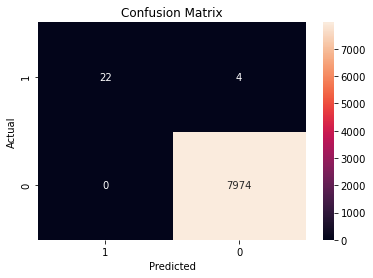

In [29]:
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")

* The model performed well, and was able to classify every normal point correctly and a majority of the anomaly points correctly